# Comparison of online NICA algorithms on synthetic sparse uniform sources

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nica_algorithms import bio_nica, bio_nica_indirect, two_layer_nsm, nonnegative_pca
from util import permutation_error, add_fill_lines

### Load desired dataset

In [14]:
# dataset = '3-dim_synthetic'
dataset = '10-dim_synthetic'

S = np.load(f'datasets/{dataset}/sources.npy')
X = np.load(f'datasets/{dataset}/mixtures.npy')

s_dim = S.shape[0]
x_dim = X.shape[0]
samples = S.shape[1]

### Online algorithms

In [15]:
trials = 1 # set the number of trials

bionica_err = np.zeros((trials,samples))
bionica_indirect_err = np.zeros((trials,samples))
nsm_err = np.zeros((trials,samples))
npca_err = np.zeros((trials,samples))

In [16]:
for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} of out {trials}:')
    
    # Random permutation of the mixtures

    idx = np.random.permutation(samples)
    
    # Noncentered whitening for Nonnegative PCA

    sig, U = np.linalg.eig(np.cov(X))

    X_white = U@np.diag(1./np.sqrt(sig))@U.T@X
    
    bionica = bio_nica(s_dim, x_dim, dataset)
    bionica_indirect = bio_nica_indirect(s_dim, x_dim, eta0=0.01, decay=1e-4, tau=0.5)
    nsm = two_layer_nsm(s_dim, x_dim, dataset, eta0=0.1, decay=0.0000001)
    npca = nonnegative_pca(s_dim, x_dim, dataset)
    
    bionica_Y = np.zeros((s_dim,samples))
    bionica_indirect_Y = np.zeros((s_dim,samples))
    nsm_Y = np.zeros((s_dim,samples))
    npca_Y = np.zeros((s_dim,samples))
    
    print('Running online algorithms...')
    
    for i_sample in range(samples):

        x = X[:,idx[i_sample]]
        x_white = X_white[:,idx[i_sample]]
        
        bionica_Y[:,i_sample] = bionica.fit_next(x)
        bionica_indirect_Y[:,i_sample] = bionica_indirect.fit_next(x)
        nsm_Y[:,i_sample] = nsm.fit_next(x)
        npca_Y[:,i_sample] = npca.fit_next(x_white)
        
        # if a neuron hasn't fired by the 100th iteration, we flip the feedforward weights:
        
        if i_sample==100:
            for j in range(s_dim):
                if bionica_Y[j,0:i_sample].sum()==0:
                    bionica.flip_weights(j)
                if bionica_indirect_Y[j,0:i_sample].sum()==0:
                    bionica_indirect.flip_weights(j)
                if nsm_Y[j,0:i_sample].sum()==0:
                    nsm.flip_weights(j)
                if npca_Y[j,0:i_sample].sum()==0:
                    npca.flip_weights(j)
        
    print('Computing errors...')

    bionica_err[i_trial,:] = permutation_error(S[:,idx],bionica_Y)
    bionica_indirect_err[i_trial,:] = permutation_error(S[:,idx],bionica_indirect_Y)
    nsm_err[i_trial,:] = permutation_error(S[:,idx],nsm_Y)
    npca_err[i_trial,:] = permutation_error(S[:,idx],npca_Y)

    print(f'Final Bio-NICA permutation error: {bionica_err[i_trial,-1]}')
    print(f'Final Bio-NICA indirect permutation error: {bionica_indirect_err[i_trial,-1]}')
    print(f'Final 2-layer NSM permutation error: {nsm_err[i_trial,-1]}')
    print(f'Final Nonnegative PCA permutation error: {npca_err[i_trial,-1]}')

Trial 1 of out 1:
Running online algorithms...
Computing errors...
Final Bio-NICA permutation error: 0.12012669471194173
Final Bio-NICA indirect permutation error: 0.4196851715844828
Final 2-layer NSM permutation error: 0.03557973554008744
Final Nonnegative PCA permutation error: 0.03517219763177863


### Comparison plots

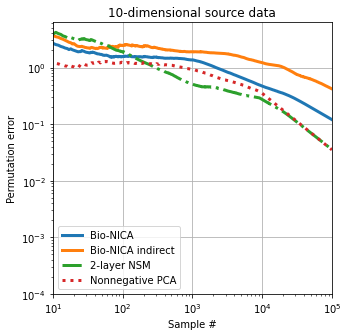

In [17]:
linewidth = 3

t = list(range(samples))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, t, bionica_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA'})
add_fill_lines(ax, t, bionica_indirect_err, plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-NICA indirect'})
add_fill_lines(ax, t, nsm_err, plot_kwargs={'ls': '-.', 'lw': linewidth, 'label': '2-layer NSM'})
add_fill_lines(ax, t, npca_err, plot_kwargs={'ls': ':', 'lw': linewidth, 'label': 'Nonnegative PCA'})

ax.loglog()

plt.title(f"{s_dim}-dimensional source data")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Sample #')
plt.ylabel('Permutation error')
plt.xlim((10,samples))
# plt.ylim(bottom=10**-4,)
plt.ylim(10**-4,10**.8)

plt.show()